In [1]:
import numpy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import os
import sys
sys.path.insert( 0, os.path.abspath( os.getenv( 'PWD' ) + '/../covid_19' ) )

In [4]:
from model import *

In [3]:
class human ( object ) :
    
    infected = False
    discovered = False
    days_sick = None
    dead = False
    healed = False
    
    def __init__ ( self, N_enc, P_spr ) :
        
        self.Ne = N_enc
        self.Ps = P_spr
        
    def infect ( self ) :
        
        self.infected = True
        self.days_sick = 0
        # self.days_crit = 10
        self.days_crit = numpy.random.randn() * 2 + 10
        # self.days_tot = 20
        self.days_tot = numpy.random.randn() * 4 + 20
        self.die_after = ( numpy.random.uniform( 0., 1. ) < 0.03 ) 
        
        return
    
    def discover ( self, N_enc = 1 ) :
        
        self.discovered = True
        self.Ne = N_enc
        
        return
    
    def update_specs ( self, Ne = None, Ps = None ) :
        
        if Ne is not None :
            self.Ne = Ne
        if Ps is not None :
            self.Ps = Ps

In [4]:
class nation () :
    
    _spec = { 'Ne' : lambda : numpy.random.uniform( 40, 60 ),
              'Ps' : lambda : 0.1,
              'Nl' : lambda : numpy.random.uniform( 1, 10 ) }
    
    def __init__ ( self, Ntotal, Ninfected, *args, **kwargs ) :
        
        self.Ntotal = Ntotal
        
        self.population = numpy.empty( shape = ( self.Ntotal, ), dtype = human )
        self.healty = numpy.arange( self.Ntotal, dtype = numpy.int32 )
        self.infected = numpy.array( [], dtype = numpy.int32 )
        self.discovered = numpy.array( [], dtype = numpy.int32 )
        self.healed = numpy.array( [], dtype = numpy.int32 )
        self.dead = numpy.array( [], dtype = numpy.int32 )
        
        self.set_people_parameters( *args, **kwargs )
        
        for ii in range( self.Ntotal ) :
            self.population[ ii ] = human( N_enc = self.extract_spec( 'Ne' ),
                                           P_spr = self.extract_spec( 'Ps' ) )
        self.infect( Ninfected )
        
    def set_people_parameters ( self, 
                                keys = [], 
                                values = [] ) :
        
        if len( keys )  != len( values ) :
            raise Exception( 'Size of input arguments invalid.' )
        for _k, _v in zip( keys, values ) :
            self._spec[ _k ] = _v
        
        return
      
    def update_people_parameters ( self, *args, **kwargs ) :
        
        self.set_people_parameters( *args, **kwargs )
        for person in self.population :
            person.update_specs( Ne = self.extract_spec( 'Ne' ), 
                                 Ps = self.extract_spec( 'Ps' ) )
            
        return
    
    def infect ( self, Ninfect ) :
        """ Infect portion of population
        
        Parameters
        ----------
        Ninfect : integer
            number of people to infect
        
        Returns
        -------
        None
        """
        
        for ii in self.healty[ :Ninfect ] :
            self.population[ ii ].infect()
        self.infected = numpy.append( self.infected, self.healty[ :Ninfect ] )
        self.healty = self.healty[ Ninfect: ]
        
        return
    
    def discover ( self, eff = 0.2 ) :
        
        for ii in self.infected :
            if ( ( self.population[ ii ].days_sick >= self.population[ ii ].days_crit ) and 
                 ( not self.population[ ii ].discovered ) and
                 ( numpy.random.uniform( 0., 1. ) < eff ) ) :
                self.population[ ii ].discover( N_enc = self.extract_spec( 'Nl' ) )
                self.discovered = numpy.append( self.discovered, ii )
        
        return
    
    def end_desease ( self ) :
        
        for ii in self.infected : 
            #[ inf for inf in self.infected if inf  :
            if ( ( self.population[ ii ].days_sick > self.population[ ii ].days_tot ) and not 
                 ( self.population[ ii ].healed ) ) :
                if not ( self.population[ ii ].die_after ) :
                    self.healed = numpy.append( self.healed, ii )
                    self.population[ ii ].Ps = 0.0
                    self.population[ ii ].healed = True
                else :
                    self.dead = numpy.append( self.dead, ii )
                    self.population[ ii ].dead = True
        self.infected = numpy.array( [ _i for _i in self.infected if not self.population[ _i ].dead ] )
        
        return
    
    def extract_spec ( self, spec ) :
        """ Extract specific datum from random uniform
        Parameters
        ----------
        spec : string
            the datum to extract 
            ( 'Ne' for number of encounters, 'Ps' for spread probability )
        Returns
        -------
        float
        """
        
        return self._spec[ spec ]()
    
    def count ( self ) :
        """ Gives the population statistics
        
        Returns
        -------
        int 
            number of infected ( comprehensive of all not discovered, discovered and healed )
        int 
            number of discovered ( comprehensive of still ill and healed )
        int 
            number of healed
        int 
            number of dead
        int
            total number of people in population ( comprehensive of still alive and already dead )
        """
        
        return len( self.infected ), len( self.discovered ), len( self.healed ), len( self.dead ), self.Ntotal
    
    def get_infected ( self ) :
        
        return self.population[ self.infected ]
    
    def get_healty ( self ) :
        
        return self.population[ self.healty ]

In [5]:
def new_infects ( encounter, P_spread, P_infected ) :
    return numpy.random.binomial( ( encounter - encounter * P_infected ), P_spread )

In [6]:
def update_time ( community, ndays, efficiency = 0.2, day0 = 0 ) :
    
    # prepare storage arrays
    days = numpy.arange( ndays )
    store_inf = numpy.empty( ndays, dtype = int )
    store_dis = numpy.empty( ndays, dtype = int )
    store_hea = numpy.empty( ndays, dtype = int )
    store_dea = numpy.empty( ndays, dtype = int )
    
    # get stats on day0
    store_inf[ 0 ], store_dis[ 0 ], store_hea[ 0 ], store_dea[ 0 ], tot = community.count()
    
    # let time pass (tic-toc-tic-toc)
    for ii in days[ 1: ] :
            
        # update the 'discovered' flag array
        community.discover( eff = efficiency )
        
        # get probability of encountering an infected
        Pi = store_inf[ ii - 1 ] / ( tot - store_dea[ ii - 1 ] )
        
        # loop on all infected to count the spreading number
        new = 0
        for infect in community.get_infected() :
            
            # add one day to sickness day count
            infect.days_sick += 1
            
            # count how many people will be infected from this poor guy
            new += new_infects( infect.Ne, 
                                infect.Ps, Pi )
        
        # new 'infect' cycle 
        community.infect( int( round( new ) ) )
        
        # update healed and dead
        community.end_desease()
        
        # store data
        store_inf[ ii ], store_dis[ ii ], store_hea[ ii ], store_dea[ ii ], _ = community.count()
        
    return days, store_inf, store_dis, store_hea, store_dea

In [5]:
%%time
italy = nation( 10**6, 3, keys = [ 'Ne', 'Ps' ], values = [ lambda : numpy.random.uniform( 40, 60 ),
                                                            lambda : 0.0025 ] )

CPU times: user 2.14 s, sys: 81.2 ms, total: 2.22 s
Wall time: 2.21 s


In [6]:
italy.count()

(3, 0, 0, 0, 1000000)

In [7]:
%%time 
days, infs, diss, heas, deas = update_time( italy, 100 )

CPU times: user 447 ms, sys: 281 µs, total: 448 ms
Wall time: 446 ms


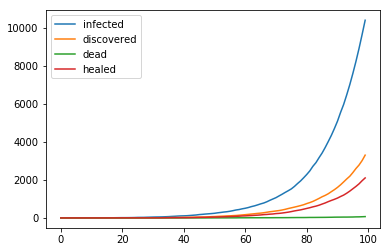

In [8]:
plt.plot( days, infs, label = 'infected' )
plt.plot( days, diss, label = 'discovered' )
plt.plot( days, deas, label = 'dead' )
plt.plot( days, heas, label = 'healed' )
plt.legend()

In [9]:
italy.count()

(10417, 3308, 2107, 69, 1000000)

In [10]:
(( diss )[61] / ( infs + deas )[50])

0.7601626016260162

In [11]:
infs[ 90 ] / diss[ 90 ]

3.1703980099502487

In [12]:
(( deas ) / ( infs + deas ))[90]

0.007978205876629695

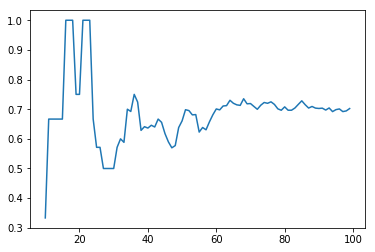

In [13]:
plt.plot( days[10:], diss[10:] / ( infs[:-10] ) )
# plt.axhline(0.2, ls='--', c='k')

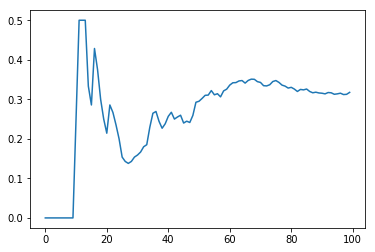

In [14]:
plt.plot( days, diss / ( infs ) )

In [12]:
italy.update_people_parameters( keys = [ 'Ne', 'Nl' ], 
                                values = [ lambda : numpy.random.uniform( 1, 4 ),
                                           lambda : numpy.random.uniform( 0, 1 ) ] )

In [13]:
italy.count()

(18118, 7211, 4451, 122, 100000)

In [14]:
%%time 
days2, infs2, diss2, heas2, deas2 = update_time( italy, 100 )

CPU times: user 5.83 s, sys: 23.3 ms, total: 5.85 s
Wall time: 5.84 s


In [17]:
italy.count()

(26835, 8245, 5414, 159, 1000000)

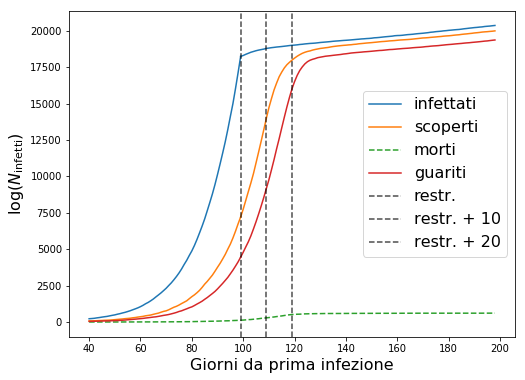

In [39]:
plt.figure( figsize = (8,6))

plt.xlabel( 'Giorni da prima infezione', fontsize = 16 )
plt.ylabel( '$\\log( N_\\mathrm{infetti})$', fontsize = 16 )

# scale = lambda x : numpy.log10( x )
scale = lambda x : x

restr = 99

plt.plot( days[40:], scale( infs[40:] + deas[40:] ), '-', color = color[ 0 ], label = 'infettati' )
plt.plot( days2 + 99, scale( infs2 + deas2 ), '-', color = color[ 0 ] )

plt.plot( days[40:], scale( diss[40:] ), '-', color = color[ 1 ], label = 'scoperti' )
plt.plot( days2 + restr, scale( diss2 ), '-', color = color[ 1 ] )

plt.plot( days[40:], scale( deas[40:] ), '--', color = color[ 2 ], label = 'morti' )
plt.plot( days2 + restr, scale( deas2 ), '--', color = color[ 2 ] )

plt.plot( days[40:], scale( heas[40:] ), '-', color = color[ 3 ], label = 'guariti' )
plt.plot( days2 + restr, scale( heas2 ), '-', color = color[ 3 ] )

plt.axvline( restr, ls = '--', color = 'k', alpha = 0.7, label = 'restr.' )
plt.axvline( restr + 10, ls = '--', color = 'k', alpha = 0.7, label = 'restr. + 10' )
plt.axvline( restr + 20, ls = '--', color = 'k', alpha = 0.7, label = 'restr. + 20' )

plt.legend( fontsize = 16 )
# plt.savefig( '../plots/simu_n1e6.png', bbox_inches = 'tight' )

In [25]:
dd = numpy.concatenate( ( days, days2 + 99 ) )
inf = numpy.concatenate( ( infs, infs2 ) )
dis = numpy.concatenate( ( diss, diss2 ) )
hea = numpy.concatenate( ( heas, heas2 ) )
dea = numpy.concatenate( ( deas, deas2 ) )

In [22]:
# numpy.savez( '../output/Ntot10e6_Ps0.0025_start3_days100+100_dead&healed', 
#              days = dd, infs = inf, diss = dis, heas = hea, deas = dea )

/opt/miniconda3/envs/learn/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


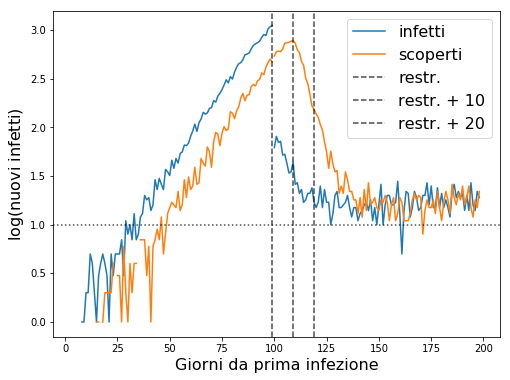

In [31]:
plt.figure( figsize = ( 8,6) )

plt.xlabel( 'Giorni da prima infezione', fontsize = 16 )
plt.ylabel( '$\\log( \\mathrm{ nuovi\\ infetti } )$', fontsize = 16 )

scale = lambda x : numpy.log10( x )

plt.plot( dd[1:], scale( numpy.diff( inf + dea ) ), label = 'infetti' )
plt.plot( dd[1:], scale( numpy.diff( dis ) ), label = 'scoperti' )

restr = 99

plt.axvline( restr, ls = '--', color = 'k', alpha = 0.7, label = 'restr.' )
plt.axvline( restr + 10, ls = '--', color = 'k', alpha = 0.7, label = 'restr. + 10' )
plt.axvline( restr + 20, ls = '--', color = 'k', alpha = 0.7, label = 'restr. + 20' )

plt.axhline( 1., ls = ':', color = 'k', alpha = 0.7 )

plt.legend( fontsize = 16 )
# plt.savefig( '../plots/simu_new-cases-per-day_n10e6.png', bbox_inches = 'tight' )